## Simple MNIST classifier

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device("cpu") # other devices "cpu" or "cuda:0", "cuda:1"

In [3]:
# instead of using nn.Sequential we can also create a new class
# which inherits from nn.Module

class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.dropout = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(3136, num_classes)
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

In [4]:
model = ConvNet()
x0 = torch.ones((1,1,28,28), requires_grad=True)
model(x0)

tensor([[ 0.0677, -0.1567, -0.0498, -0.0094,  0.0231, -0.1795, -0.0776, -0.0273,
          0.1172,  0.0322]], grad_fn=<AddmmBackward0>)

In [5]:
# load dataset
tr = transforms.Compose([transforms.ToTensor(), 
                       #  transforms.Normalize((0.1307,), (0.3081,))
                        ])

training_data = torchvision.datasets.MNIST(root='./data', train=True, transform=tr)
training_loader = torch.utils.data.DataLoader(training_data, batch_size=128, shuffle=True)

test_data = torchvision.datasets.MNIST(root='./data', train=False, transform=tr)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=10, shuffle=True)

In [6]:
# model to gpu
model = model.to(device)

# the function parameters() is implemented in nn.Module
params = model.parameters()

In [7]:
cross_entropy = nn.CrossEntropyLoss() # instantiate loss 
opt = optim.Adam(params, lr=0.001) # instantiate optimizer

In [8]:
epochs = 2
history = []

for i in range(0, epochs):
    for j,(inputs, labels) in enumerate(training_loader):
        
        # put data on GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        opt.zero_grad()

        # forward pass
        outputs = model(inputs)
        
        # training loss
        loss = cross_entropy(outputs, labels)
        history.append(loss.item())
        
        # backward pass
        loss.backward()
        opt.step()

        if (j+1) % 100 == 0:
            print("epoch: {:2} batch: {:4} loss: {:3.4}".format(i+1,j+1,history[-1]))

epoch:  1 batch:  100 loss: 0.2793
epoch:  1 batch:  200 loss: 0.1233
epoch:  1 batch:  300 loss: 0.1395
epoch:  1 batch:  400 loss: 0.09635
epoch:  2 batch:  100 loss: 0.1584
epoch:  2 batch:  200 loss: 0.1291
epoch:  2 batch:  300 loss: 0.1247
epoch:  2 batch:  400 loss: 0.09578


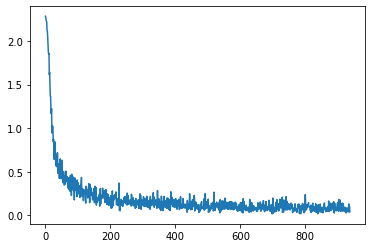

In [9]:
plt.plot(history);

In [10]:
# set model to evaluation mode 
# (important for batchnorm/dropout)
model.train(False)
model.eval()

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc): Linear(in_features=3136, out_features=10, bias=True)
)

In [11]:
total = 0
correct = 0

for j,(inputs, labels) in enumerate(test_loader):
    test_output = model(inputs.to(device)).cpu()
    predicted_class = test_output.max(dim = 1)[1]
    correct += torch.sum(predicted_class == labels).float().item() 
    total += inputs.shape[0]
    
correct/total

0.984

In [12]:
# Save model to disk
torch.save(model.state_dict(), "mnist-convnet-model.pth")

In [13]:
# Load model
model = ConvNet()
model.load_state_dict(torch.load("mnist-convnet-model.pth"))

<All keys matched successfully>

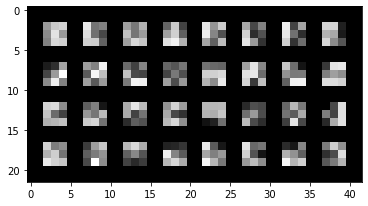

In [14]:
from torchvision.utils import make_grid
params = list(model.parameters())
f = params[0].detach()
f = (f-f.min())/(f.max()-f.min()) # normalize filters to [0,1]
plt.imshow(make_grid(f).permute(1,2,0))